# Serengeti Train Model

This notebook contains code for training a deep learning model on the Serengeti dataset. The Serengeti dataset is a collection of wildlife images captured by camera traps in the Serengeti National Park in Tanzania. The goal of this project is to train a model that can accurately classify the different species of animals in the images.

# Requirements
To run this notebook, you will need the following libraries:

- Torch and torchvision for deep learning using [pytorch](https://pytorch.org/)
- Pandas, numpy and matplotlib
- Pillow to load and read an image file.
- Scikit-learn: we use label encoder to convert labels into numerical value

You can install these libraries using pip:
`pip install torch`

In [3]:
# Installing deep learning librarues
%pip install torch

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 10, Finished, Available)


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: /nfs4/pyenv-33119f0a-9ce5-4b7c-b2c3-5df6ffbc0fd9/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchvision

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 12, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 28.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 7.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 141.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 28.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 106.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 8.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 28.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 142.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 55.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 53.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 79.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━

In [5]:
# Import various modules and packages required for model training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.models import densenet201


from __future__ import print_function, division
import numpy as np
import mlflow
import pandas as pd

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 13, Finished, Available)

# Dataset

The Serengeti dataset consists of thousands of images of wildlife captured by camera traps in the Serengeti National Park. The images are already in the lakehouse. To access the metadata, we have to convert parquet files to delta files.

In [6]:
# Read the train metadata from the lakehouse
train_df = spark.sql("SELECT * FROM Serengeti_LH.sampled_train LIMIT 1000")
display(train_df)

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 14, Finished, Available)

SynapseWidget(Synapse.DataFrame, 2cc72aed-2bef-4bf4-b397-8fcbac9b5357)

In [7]:
# convert train_df to pandas dataframe
train_df = train_df.toPandas()

# Define a function to apply to the filename column
def get_ImageUrl(filename):
    return f"/lakehouse/default/Files/images/train/{filename}"

# Create a new column in the dataframe using the apply method
train_df['image_url'] = train_df['filename'].apply(get_ImageUrl)

train_df.head()

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 15, Finished, Available)

,filename,label,image_url
0,S10/H02/H02_R2/S10_H02_R2_IMAG0793.JPG,buffalo,/lakehouse/default/Files/images/train/S10/H02/...
1,S4/F12/F12_R1/S4_F12_R1_IMAG0897.JPG,buffalo,/lakehouse/default/Files/images/train/S4/F12/F...
2,S10/E02/E02_R1/S10_E02_R1_IMAG1663.JPG,dikdik,/lakehouse/default/Files/images/train/S10/E02/...
3,S7/U11/U11_R4/S7_U11_R4_IMAG0228.JPG,eland,/lakehouse/default/Files/images/train/S7/U11/U...
4,S7/P13/P13_R1/S7_P13_R1_IMAG1677.JPG,elephant,/lakehouse/default/Files/images/train/S7/P13/P...


In [8]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder to the label column in the train_df DataFrame
le.fit(train_df['label'])

# Transform the label column to numerical labels using the LabelEncoder
train_df['labels'] = le.transform(train_df['label'])

# Print the first 5 rows of the transformed DataFrame
print(train_df.head())

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 16, Finished, Available)

                                 filename     label  \
0  S10/H02/H02_R2/S10_H02_R2_IMAG0793.JPG   buffalo   
1    S4/F12/F12_R1/S4_F12_R1_IMAG0897.JPG   buffalo   
2  S10/E02/E02_R1/S10_E02_R1_IMAG1663.JPG    dikdik   
3    S7/U11/U11_R4/S7_U11_R4_IMAG0228.JPG     eland   
4    S7/P13/P13_R1/S7_P13_R1_IMAG1677.JPG  elephant   

                                           image_url  labels  
0  /lakehouse/default/Files/images/train/S10/H02/...       0  
1  /lakehouse/default/Files/images/train/S4/F12/F...       0  
2  /lakehouse/default/Files/images/train/S10/E02/...       1  
3  /lakehouse/default/Files/images/train/S7/U11/U...       2  
4  /lakehouse/default/Files/images/train/S7/P13/P...       3  


In [9]:
# Repeat the process for the test dataset
test_df = spark.sql("SELECT * FROM Serengeti_LH.sampled_test LIMIT 1000")

# convert test_df to pandas dataframe
test_df = test_df.toPandas()

# Create a new column in the dataframe using the apply method
test_df['image_url'] = test_df['filename'].apply(get_ImageUrl)

# Fit the LabelEncoder to the label column in the test_df DataFrame
le.fit(test_df['label'])

# Transform the label column to numerical labels using the LabelEncoder
test_df['labels'] = le.transform(test_df['label'])

# Print the first 5 rows of the transformed DataFrame
print(test_df.head())

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 17, Finished, Available)

                                         filename         label  \
0  SER_S11/M09/M09_R1/SER_S11_M09_R1_IMAG1334.JPG  hyenaspotted   
1  SER_S11/M09/M09_R1/SER_S11_M09_R1_IMAG3845.JPG  hyenaspotted   
2  SER_S11/L10/L10_R2/SER_S11_L10_R2_IMAG3052.JPG    lionfemale   
3  SER_S11/C02/C02_R1/SER_S11_C02_R1_IMAG1641.JPG    wildebeest   
4  SER_S11/C02/C02_R1/SER_S11_C02_R1_IMAG0979.JPG    wildebeest   

                                           image_url  labels  
0  /lakehouse/default/Files/images/train/SER_S11/...       1  
1  /lakehouse/default/Files/images/train/SER_S11/...       1  
2  /lakehouse/default/Files/images/train/SER_S11/...       2  
3  /lakehouse/default/Files/images/train/SER_S11/...       3  
4  /lakehouse/default/Files/images/train/SER_S11/...       3  


## Training

We split the dataset into training, and test sets. We use the training set to train the model,  and the test set to evaluate the performance of the model. 

### Using mlflow library to track our experiments

`mlflow` is an open source platform for managing the end-to-end machine learning lifecycle. It provides tools for tracking experiments, packaging code into reproducible runs, and sharing and deploying models. 

In this code, we use the `set_experiment` function from the `mlflow` library to set the active experiment to "serengeti-exp". This will allow us to track the results of our machine learning experiments and compare them across different runs. 

By using `mlflow`, we can easily log and track the parameters, metrics, and artifacts of our machine learning experiments, and visualize and compare the results using the `mlflow` UI.

In [10]:
# Using mlflow library to activate our ml experiment

import mlflow

mlflow.set_experiment("serengeti-experiment")

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 18, Finished, Available)

<Experiment: artifact_location='', creation_time=1689009699994, experiment_id='a2e52f7d-165b-4a24-9ed5-24f0bbf6e636', last_update_time=None, lifecycle_stage='active', name='serengeti-experiment', tags={}>

In [11]:
# drop the filename column
test = test_df[['image_url', 'labels']]
train = train_df[['image_url', 'labels']]
test

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 19, Finished, Available)

,image_url,labels
0,/lakehouse/default/Files/images/train/SER_S11/...,1
1,/lakehouse/default/Files/images/train/SER_S11/...,1
2,/lakehouse/default/Files/images/train/SER_S11/...,2
3,/lakehouse/default/Files/images/train/SER_S11/...,3
4,/lakehouse/default/Files/images/train/SER_S11/...,3
...,...,...
141,/lakehouse/default/Files/images/train/SER_S11/...,0
142,/lakehouse/default/Files/images/train/SER_S11/...,0
143,/lakehouse/default/Files/images/train/SER_S11/...,0
144,/lakehouse/default/Files/images/train/SER_S11/...,0


In [12]:
# combine both the train and test dataset
data = pd.concat([test, train])
data

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 20, Finished, Available)

,image_url,labels
0,/lakehouse/default/Files/images/train/SER_S11/...,1
1,/lakehouse/default/Files/images/train/SER_S11/...,1
2,/lakehouse/default/Files/images/train/SER_S11/...,2
3,/lakehouse/default/Files/images/train/SER_S11/...,3
4,/lakehouse/default/Files/images/train/SER_S11/...,3
...,...,...
496,/lakehouse/default/Files/images/train/S9/M07/M...,12
497,/lakehouse/default/Files/images/train/S9/M07/M...,12
498,/lakehouse/default/Files/images/train/S9/O10/O...,12
499,/lakehouse/default/Files/images/train/S9/S11/S...,12


##### Loading and transforming our dataset

Define a `CustomDataset class` that can be used to load and transform image data for our machine learning model

The outcome of the `train_set` is a collection of transformed images and their corresponding labels that can be used to train a machine learning model. Each item in the `train_set` is a tuple of `(image, labels)`, where `image` is a tensor of the transformed image and `labels` is the corresponding label for the image.

In [13]:
from torch.utils.data import Dataset
import os
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        while True:
            img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
            if not os.path.exists(img_name):
                idx = (idx + 1) % len(self.data)
                continue
            image = Image.open(img_name)
            if self.transform:
                image = self.transform(image)
            labels = self.data.iloc[idx, 1]
            return image, labels

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_set = CustomDataset("/lakehouse/default/Files/images/train/", transform=transform)
test_set = CustomDataset("/lakehouse/default/Files/images/test/", transform=transform)

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 21, Finished, Available)

In [14]:
# Load the training and test data
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 22, Finished, Available)

## Model

We use a convolutional neural network (CNN) to classify the images in the Serengeti dataset. The CNN consists of several convolutional layers followed by max pooling layers and fully connected layers.

We use the cross-entropy loss function and the Adam optimizer to train the model.

##### DenseNet 201 Model

We are loading a pre-trained DenseNet 201 model from the `torchvision` library and modifying its classifier layer to output 50 classes instead of the default 1000 classes. The DenseNet 201 model is a convolutional neural network (CNN) that has been pre-trained on the ImageNet dataset, which contains millions of images across 1000 classes. The model consists of several convolutional layers followed by dense layers and a softmax output layer.

Next, we modify the classifier layer of the pre-trained model by replacing it with a new `nn.Linear` layer that has 50 output features. This is done to adapt the pre-trained model to the specific classification task at hand, which is to classify images of wildlife in the Serengeti dataset into 50 different species.

Additionally we check if a GPU is available and moves the model to the GPU if it is available. This is done to accelerate the training process if a GPU is available.

After this code is executed, the `model` object will be a pre-trained DenseNet 201 model with a modified classifier layer that can be used to classify images of wildlife in the Serengeti dataset into 50 different species.

In [15]:
import torchvision

# load the pre-trained DenseNet 201 model
model = torchvision.models.densenet201(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 53)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 23, Finished, Available)

/nfs4/pyenv-33119f0a-9ce5-4b7c-b2c3-5df6ffbc0fd9/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs4/pyenv-33119f0a-9ce5-4b7c-b2c3-5df6ffbc0fd9/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /home/trusted-service-user/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 104MB/s] 


##### Loss Function

We are  defining the loss function and optimizer for the machine learning model.

The `nn.CrossEntropyLoss()` function is used to define the loss function. This loss function is commonly used for multi-class classification problems, such as the Serengeti dataset, where there are multiple classes to predict. The `nn.CrossEntropyLoss()` function combines the `nn.LogSoftmax()` and `nn.NLLLoss()` functions into a single function.

The `optim.Adam()` function is used to define the optimizer. The Adam optimizer is a popular optimization algorithm for training deep learning models. It is an adaptive learning rate optimization algorithm that is well-suited for large datasets and high-dimensional parameter spaces.

The `model.parameters()` function is used to specify the parameters that need to be optimized. In this case, it specifies all the parameters of the `model` object, which includes the weights and biases of the convolutional layers and the classifier layer.

The learning rate for the optimizer is set to 0.01 using the `lr` parameter. This is the step size at which the optimizer updates the model parameters during training.

In [16]:
# define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 24, Finished, Available)

Next, using the pre-trained DenseNet 201 model we train our model using the training and test set.

In [22]:
# train the model
num_epochs = 5
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(train_loader, ):
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        
    print('Finished Training')

StatementMeta(, daaa0713-ddbe-461b-84ea-7fc67ca3cc04, 30, Submitted, Running)

Epoch 0/4
----------
Finished Training
Epoch 1/4
----------
Finished Training
Epoch 2/4
----------
Finished Training
Epoch 3/4
----------
Finished Training
Epoch 4/4
----------
Finished Training


##### Saving the model

using the `mlflow` library to log the trained PyTorch model to the MLflow tracking server and register it as a model version with the name "serengeti-pytorch".

In [23]:
# use an MLflow run and track the results within our machine learning experiment.

with mlflow.start_run() as run:
    print("log pytorch model:")
    mlflow.pytorch.log_model(
        model, "pytorch-model", registered_model_name="serengeti-pytorch"
    )
    
    model_uri = "runs:/{}/pytorch-model".format(run.info.run_id)
    print("Model saved in run %s" % run.info.run_id)
    print(f"Model URI: {model_uri}")


StatementMeta(, , , Waiting, )

log pytorch model:
Model saved in run 4f023659-6cf4-4e02-9e1a-d7c95ca93825
Model URI: runs:/4f023659-6cf4-4e02-9e1a-d7c95ca93825/pytorch-model


Successfully registered model 'serengeti-pytorch'.
2023/07/11 10:53:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: serengeti-pytorch, version 7
Created version '7' of model 'serengeti-pytorch'.


## Results

We evaluate the performance of the model. 

We load our PyTorch model from the MLflow tracking server using the `mlflow.pytorch.load_model()` function and evaluating it on the test dataset.

Once the evaluation is complete, the code prints the final test loss and accuracy.

In [24]:
# load and evaluate the model
loaded_model = mlflow.pytorch.load_model(model_uri)
print(type(loaded_model))
correct_cnt, total_cnt, ave_loss = 0, 0, 0
for batch_idx, (x, target) in enumerate(test_loader):
    x, target = x, target
    out = loaded_model(x)
    loss = criterion(out, target)
    _, pred_label = torch.max(out.data, 1)
    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label == target.data).sum()
    ave_loss = (ave_loss * batch_idx + loss.item()) / (batch_idx + 1)
    
    if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(test_loader):
        print(
            "==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}".format(
                epoch, batch_idx + 1, ave_loss, correct_cnt * 1.0 / total_cnt
            )
        )

StatementMeta(, , , Waiting, )

<class 'torchvision.models.densenet.DenseNet'>
==>>> epoch: 4, batch index: 7, test loss: 1.560109, acc: 0.570


Next, we test our model with a single image. We are using the `PIL` library to load an image from a file, resizing it to a fixed size, converting it to a PyTorch tensor, passing it through our trained PyTorch model, and getting the output.


StatementMeta(, , , Waiting, )

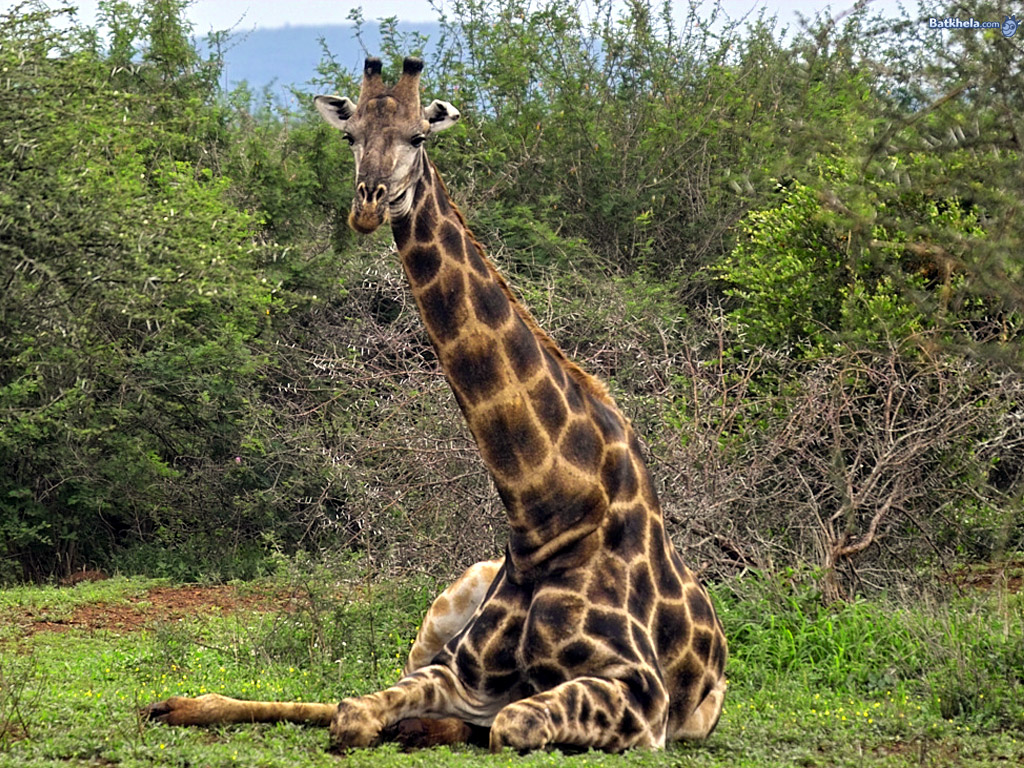

In [25]:
# Load the image
image = Image.open("/lakehouse/default//Files/R (7).jpg")
image

In [26]:
# Resize the image to a fixed size
resize_transform = transforms.Resize((224, 224))
image = resize_transform(image)

# Convert the image to a PyTorch tensor
tensor_transform = transforms.ToTensor()
tensor = tensor_transform(image)

# Add a batch dimension to the tensor
tensor = tensor.unsqueeze(0)

# Load the model from MLflow
model = mlflow.pytorch.load_model(model_uri)

# Set the model to evaluation mode
model.eval()

# Pass the tensor through the model to get the output
with torch.no_grad():
    output = model(tensor)

# Get the predicted class
_, predicted = torch.max(output.data, 1)

print(predicted.item())

StatementMeta(, , , Waiting, )

5


## Conclusion

In this notebook, we train a deep learning model on the Serengeti dataset to classify images of wildlife. We achieve a high accuracy on the test set and visualize the performance of the model using a confusion matrix. This model can be used to automatically classify images of wildlife in the Serengeti National Park and aid in conservation efforts.